In [1]:
!pip install sktime
!pip install skforecast
!pip install pmdarima

In [120]:
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from dateutil.parser import parse
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import seaborn as sns
plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120}) # set figure sizes
import matplotlib.ticker as mtick
plt.style.use('fivethirtyeight')

In [121]:
df_ts = pd.read_csv('meat_supply_per_person_kg_world.csv',
                 index_col='date',parse_dates=['date'])

df_ts.head()

,meat_kgs
date,
1961-01-01,22.951147
1962-01-01,23.581467
1963-01-01,24.301382
1964-01-01,24.240559
1965-01-01,24.905693


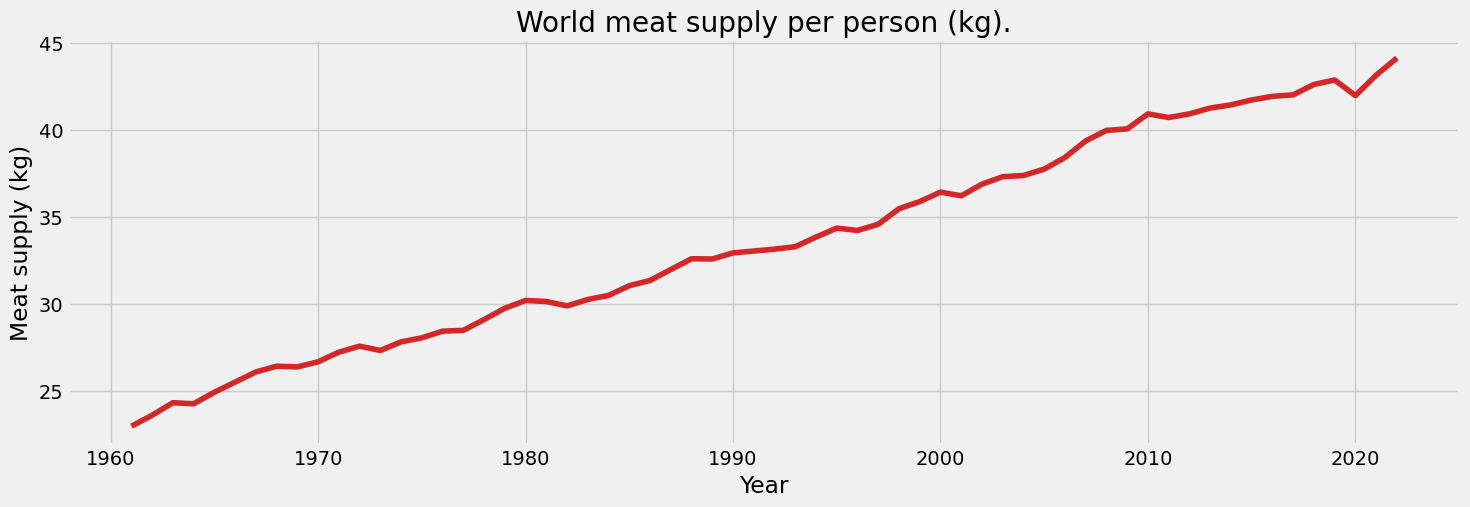

In [122]:
def plot_df(df_ts, x, y, title="", xlabel='Year', ylabel='Meat supply (kg)', dpi=100):
 
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(df_ts, df_ts.index, y=df_ts.meat_kgs, title='World meat supply per person (kg).')

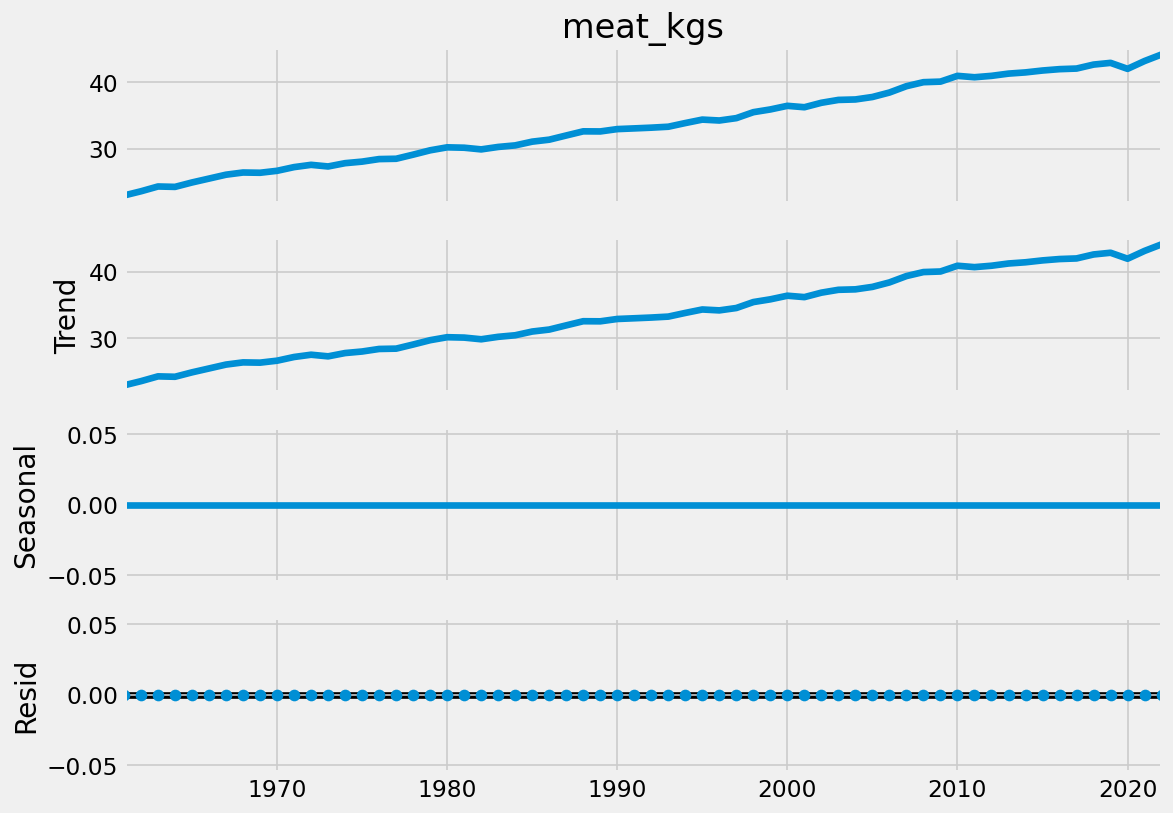

In [123]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

# Additive Decomposition ( components are added together)

# result_add. will hold the components
result_add = seasonal_decompose(df_ts['meat_kgs'], model='additive', extrapolate_trend='freq')

# Plot
result_add.plot()
plt.show()

In [15]:
import pandas as pd
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.base import ForecastingHorizon
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
# Plots
# ==============================================================================
import matplotlib.pyplot as plt
from sktime.datasets import load_airline
from sktime.utils.plotting import plot_series
# Modeling and Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster

# Warnings configuration
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [124]:
# Verify that a temporary index is complete
# ==============================================================================
freq = 'YS'   # specify the type of frequency YS = Year start

print(df_ts.index.min())
print(df_ts.index.max())

# Step 1: Generate a complete date range with the specified frequency
complete_range = pd.date_range(start=df_ts.index.min(), end=df_ts.index.max(), freq=freq)

# Step 3: Check for completeness
# Convert both the DataFrame index and the complete_range to sets and check if they are equal
is_complete = set(df_ts.index) == set(complete_range)

print(f"Is the temporal index complete? {is_complete}")

1961-01-01 00:00:00
2022-01-01 00:00:00
Is the temporal index complete? True


In [125]:
# Data preparation
data = df_ts
data['date'] = pd.to_datetime(data.index, format='%Y-%m-%d')
data = data.set_index('date')
data = data.asfreq('YS')
data = data.sort_index()
data.head()

,meat_kgs
date,
1961-01-01,22.951147
1962-01-01,23.581467
1963-01-01,24.301382
1964-01-01,24.240559
1965-01-01,24.905693


In [126]:
data.index.freq

<YearBegin: month=1>

In [127]:
print(f'Number of rows with missing values: {data.isnull().any(axis=1).mean()}')

print(f'Shape is {data.shape}')

Number of rows with missing values: 0.0
Shape is (62, 1)


Train dates : 1961-01-01 00:00:00 --- 2007-01-01 00:00:00  (n=47)
Test dates  : 2008-01-01 00:00:00 --- 2022-01-01 00:00:00  (n=15)


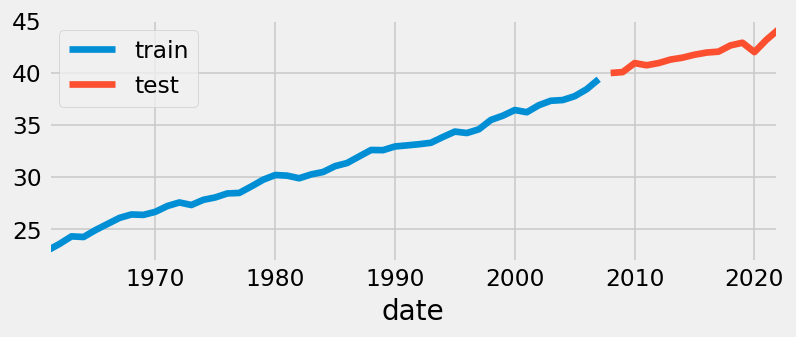

In [128]:
# Split data into train-test
# We are going to train on the first 47 years and test on the last 15 years
# ==============================================================================
steps = 15 # going to predict the final 15 years
data_train = data[:-steps]   # this sets data_train to be all values EXCEPT the last 15

data_test  = data[-steps:]   # this sets data_test to be the last 15 values

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

fig, ax = plt.subplots(figsize=(7, 2.5))
data_train['meat_kgs'].plot(ax=ax, label='train')
data_test['meat_kgs'].plot(ax=ax, label='test')
ax.legend();

In [129]:
# Function for accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None],
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None],
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax

    return({'mape':mape, 'me':me, 'mae': mae,
            'mpe': mpe, 'rmse':rmse,
            'corr':corr, 'minmax':minmax})

In [22]:
from skforecast.Sarimax import Sarimax
from skforecast.ForecasterSarimax import ForecasterSarimax
from pmdarima import ARIMA
from skforecast.model_selection_sarimax import backtesting_sarimax
from skforecast.model_selection_sarimax import grid_search_sarimax

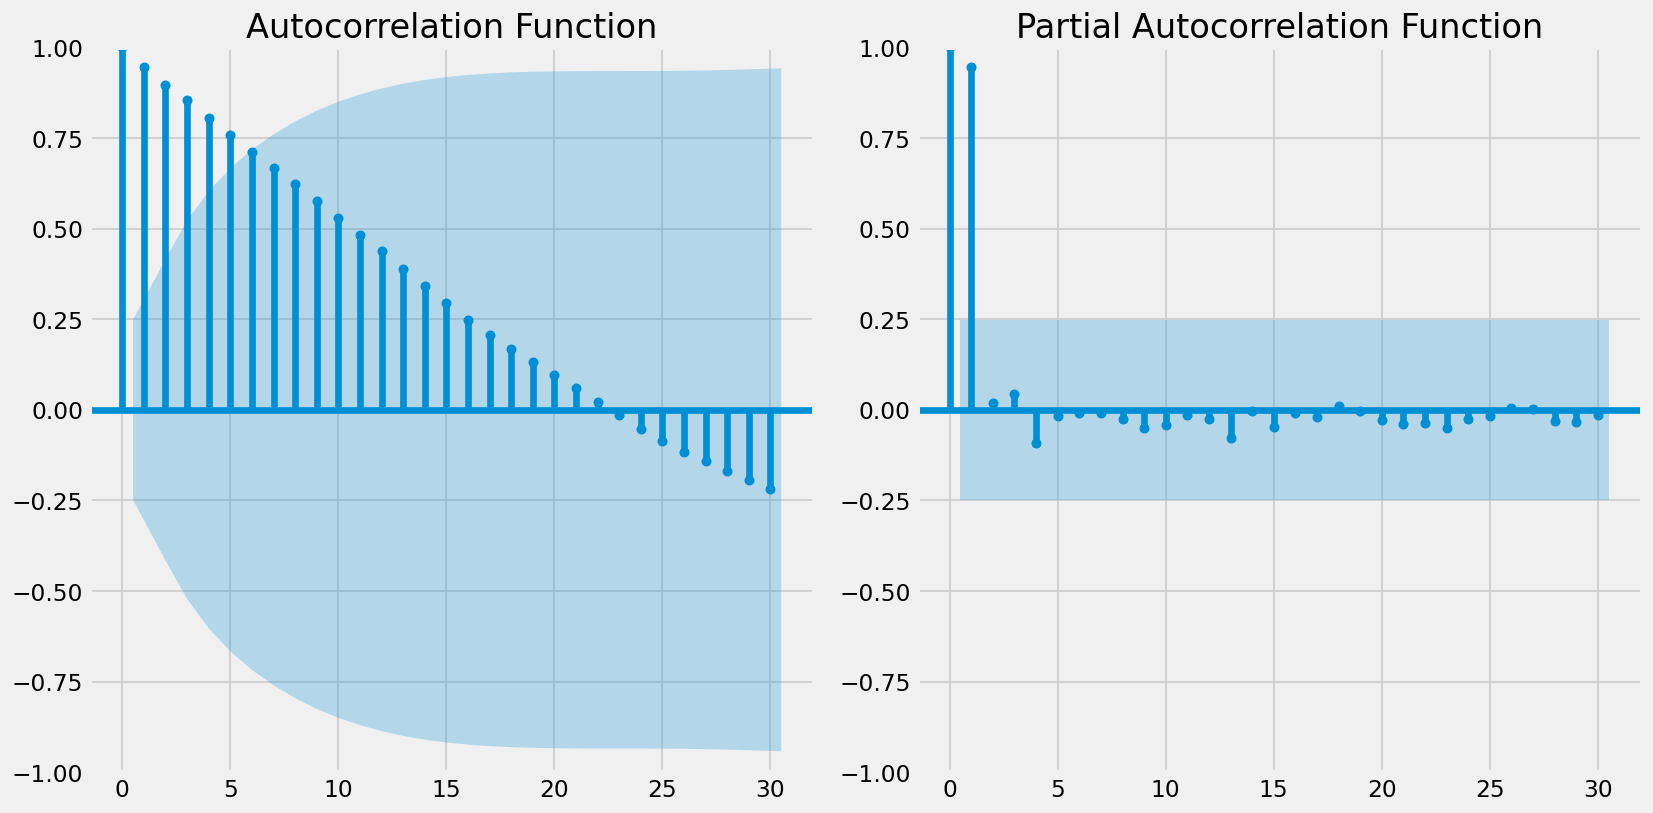

In [130]:
# Test for seasonality - Auotocorrelation Function plot (ACF)

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plotting the Autocorrelation Function (ACF)
plt.figure(figsize=(14, 7))
plt.subplot(121)
plot_acf(data['meat_kgs'], ax=plt.gca(), lags=30, title='Autocorrelation Function')

# Plotting the Partial Autocorrelation Function (PACF)
plt.subplot(122)
plot_pacf(data['meat_kgs'], ax=plt.gca(), lags=30, title='Partial Autocorrelation Function')

plt.tight_layout()
plt.show()

In [70]:
!pip install pmdarima

In [131]:
#building the model
from pmdarima.arima import auto_arima
arima_model = auto_arima(data_train, start_p=0, d=1, start_q=0, max_p=5, max_d=5, max_q=5, start_P=0, D=1, start_Q=0, max_P=5, max_D=5, max_Q=5, m=12, 
                         seasonal=False, error_action='warn', trace = True, suppress_warnings=True, 
                         stepwise=True, random_state=20, n_fits = 50)




Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=23.137, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=25.135, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=25.133, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=62.054, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=26.174, Time=0.43 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.906 seconds


In [132]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   47
Model:               SARIMAX(0, 1, 0)   Log Likelihood                  -9.568
Date:                Fri, 02 May 2025   AIC                             23.137
Time:                        21:44:18   BIC                             26.794
Sample:                    01-01-1961   HQIC                            24.507
                         - 01-01-2007                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3567      0.046      7.734      0.000       0.266       0.447
sigma2         0.0888      0.024      3.768      0.000       0.043       0.135
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.75
Prob(Q):                              0.97   Prob(JB):                         0.42
Heteroskedasticity (H):               1.39   Skew:                            -0.36
Prob(H) (two-sided):                  0.53   Kurtosis:                         2.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [133]:
prediction = pd.DataFrame(arima_model.predict(n_periods = 15),index=data_test.index)
prediction.columns = ['predicted_meat_supply']
prediction

,predicted_meat_supply
date,
2008-01-01,39.718363
2009-01-01,40.075113
2010-01-01,40.431862
2011-01-01,40.788611
2012-01-01,41.145360
2013-01-01,41.502110
2014-01-01,41.858859
2015-01-01,42.215608
2016-01-01,42.572358


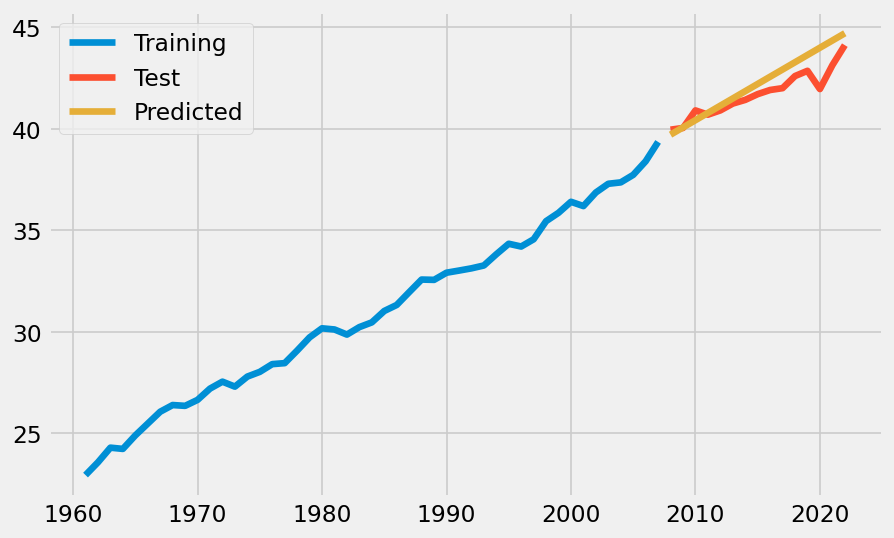

In [134]:
plt.figure(figsize=(8,5))
plt.plot(data_train,label="Training")
plt.plot(data_test,label="Test")
plt.plot(prediction,label="Predicted")
plt.legend(loc = 'upper left')
plt.show()

In [135]:
from sklearn.metrics import r2_score
data_test['predicted_meat_supply'] = prediction
r2_score(data_test['meat_kgs'], data_test['predicted_meat_supply'])

0.507953929116781

In [136]:
mape(prediction, data_test.meat_kgs)

3.8039852254260493